<a href="https://colab.research.google.com/github/Muhammad-Lutfi-2002/ENCRYPTIX/blob/main/imdb_india.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Optional: Handle warnings more specifically
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Read the dataset
try:
    df = pd.read_csv('IMDb Movies India.csv', encoding='latin-1')

    # Display basic information about the dataset
    print("Dataset Info:")
    df.info()

    print("\nFirst few rows:")
    print(df.head())

except FileNotFoundError:
    print("File 'IMDb Movies India.csv' tidak ditemukan. Pastikan file berada di direktori yang benar.")
except pd.errors.EmptyDataError:
    print("File kosong.")
except Exception as e:
    print(f"Terjadi kesalahan: {e}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB

First few rows:
                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (

In [6]:
def preprocess_data(df):
    # Fungsi untuk mengonversi kolom ke tipe data yang sesuai
    def safe_convert_column(df, column, conversion_func):
        try:
            # Konversi kolom ke string terlebih dahulu jika perlu
            if not pd.api.types.is_string_dtype(df[column]):
                df[column] = df[column].astype(str)

            # Terapkan fungsi konversi
            return conversion_func(df[column])
        except Exception as e:
            print(f"Error converting column {column}: {e}")
            return df[column]

    # Konversi Year
    df['Year'] = safe_convert_column(df, 'Year',
        lambda x: pd.to_numeric(x.str.extract('(\d+)')[0], errors='coerce')
    )

    # Konversi Duration
    df['Duration'] = safe_convert_column(df, 'Duration',
        lambda x: pd.to_numeric(x.str.extract('(\d+)')[0], errors='coerce')
    )

    # Konversi Rating
    df['Rating'] = safe_convert_column(df, 'Rating',
        lambda x: pd.to_numeric(x, errors='coerce')
    )

    # Konversi Votes
    df['Votes'] = safe_convert_column(df, 'Votes',
        lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')
    )

    # Hapus baris dengan data krusial yang hilang
    df = df.dropna(subset=['Name', 'Year'], how='all')

    # Fungsi untuk menghapus outliers dengan pendekatan yang aman
    def remove_outliers_safe(data, column, threshold=3):
        if column not in data.columns:
            return data

        # Pastikan kolom numerik
        data[column] = pd.to_numeric(data[column], errors='coerce')

        # Hitung Z-score
        z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())

        # Kembalikan data yang tidak termasuk outliers
        return data[z_scores < threshold]

    # Terapkan remove outliers untuk kolom numerik
    numeric_columns = ['Rating', 'Votes', 'Duration']
    for col in numeric_columns:
        df = remove_outliers_safe(df, col)

    # Bersihkan kolom Genre jika ada
    if 'Genre' in df.columns:
        try:
            df['Genre'] = df['Genre'].astype(str).str.split(',').str[0].str.strip()
        except Exception as e:
            print(f"Error processing Genre column: {e}")

    return df

# Fungsi laporan kualitas data
def data_quality_report(df):
    print("Data Quality Report:")
    print("Total rows:", len(df))
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nColumn Data Types:")
    print(df.dtypes)
    print("\nUnique Values per Categorical Column:")
    for column in df.select_dtypes(include=['object']).columns:
        print(f"{column}: {df[column].nunique()} unique values")

    print("\nValue Ranges for Numeric Columns:")
    numeric_columns = ['Year', 'Duration', 'Rating', 'Votes']
    for col in numeric_columns:
        try:
            print(f"{col}: Min = {df[col].min()}, Max = {df[col].max()}")
        except Exception as e:
            print(f"Could not process column {col}: {e}")

# Terapkan preprocessing dan laporan kualitas data
df_clean = preprocess_data(df)
data_quality_report(df_clean)

Data Quality Report:
Total rows: 5718

Missing Values:
Name          0
Year          0
Duration      0
Genre         0
Rating        0
Votes         0
Director      1
Actor 1      68
Actor 2     106
Actor 3     146
dtype: int64

Column Data Types:
Name         object
Year        float64
Duration    float64
Genre        object
Rating      float64
Votes       float64
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

Unique Values per Categorical Column:
Name: 5443 unique values
Genre: 21 unique values
Director: 2505 unique values
Actor 1: 2004 unique values
Actor 2: 2336 unique values
Actor 3: 2538 unique values

Value Ranges for Numeric Columns:
Year: Min = 1931.0, Max = 2021.0
Duration: Min = 53.0, Max = 211.0
Rating: Min = 1.7, Max = 9.7
Votes: Min = 5.0, Max = 35121.0


In [9]:
def perform_eda(df):
    # Set up the plotting style
    plt.style.use('seaborn')

    # 1. Basic Statistics
    print("\nNumerical Columns Statistics:")
    print(df.describe())
    # 2. Missing Values Analysis
    print("\nMissing Values:")
    missing_data = df.isnull().sum()
    missing_percentage = 100 * df.isnull().sum() / len(df)
    missing_table = pd.concat([missing_data, missing_percentage], axis=1, keys=['Total Missing', 'Percentage Missing'])
    print(missing_table[missing_table['Total Missing'] > 0])
    print("\nUnique Values in Categories:")
    categorical_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
    for col in categorical_cols:
        print(f"\n{col}:")
        print(f"Unique Values: {df[col].nunique()}")
        print(f"Top 5 {col}s:")
        print(df[col].value_counts().head())

In [12]:
def analyze_trends(df):
    # Year with best rating
    best_year = df.groupby('Year')['Rating'].mean().sort_values(ascending=False)
    print("\nBest Years by Average Rating:")
    print(best_year.head())

    # Correlation between duration and rating
    correlation = df['Duration'].corr(df['Rating'])
    print(f"\nCorrelation between Duration and Rating: {correlation:.2f}")

    # Top 10 movies by rating
    top_movies = df.nlargest(10, 'Rating')[['Name', 'Year', 'Rating', 'Votes']]
    print("\nTop 10 Movies by Rating:")
    print(top_movies)

    # Most prolific directors
    top_directors = df['Director'].value_counts().head(10)
    print("\nMost Prolific Directors:")
    print(top_directors)

    # Most appearing actors
    actors = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']])
    top_actors = actors.value_counts().head(10)
    print("\nMost Appearing Actors:")
    print(top_actors)

# Perform analysis
analyze_trends(df_clean)


Best Years by Average Rating:
Year
1944.0    7.22000
1952.0    7.21250
1940.0    7.05000
1957.0    7.04375
1953.0    6.95500
Name: Rating, dtype: float64

Correlation between Duration and Rating: -0.04

Top 10 Movies by Rating:
                      Name    Year  Rating   Votes
5410            Half Songs  2021.0     9.7     7.0
5077          Gho Gho Rani  2019.0     9.4    47.0
6852                  June  2021.0     9.4    18.0
14222  The Reluctant Crime  2020.0     9.4    16.0
1314          Ashok Vatika  2018.0     9.3     7.0
1729              Baikunth  2021.0     9.3    29.0
5125           God of gods  2019.0     9.3    46.0
8344          Love Sorries  2021.0     9.3    79.0
11843              Refl3ct  2021.0     9.3   467.0
12673   Secrets of Sinauli  2021.0     9.3  1373.0

Most Prolific Directors:
Director
David Dhawan            40
Mahesh Bhatt            38
Shakti Samanta          34
Ram Gopal Varma         33
Hrishikesh Mukherjee    33
Vikram Bhatt            30
Priyadarshan 

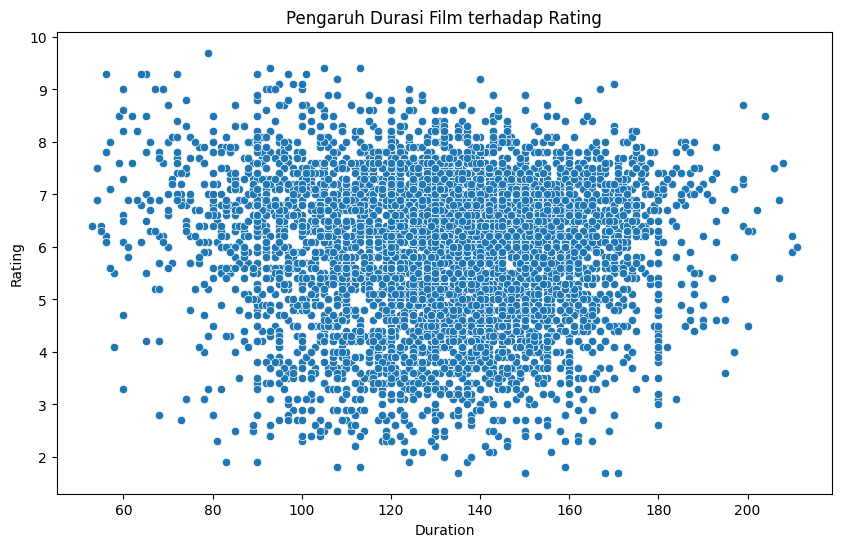

In [16]:
   # Visualisasi Durasi vs Rating
   plt.figure(figsize=(10, 6))
   sns.scatterplot(x='Duration', y='Rating', data=df_clean)
   plt.title('Pengaruh Durasi Film terhadap Rating')
   plt.show()

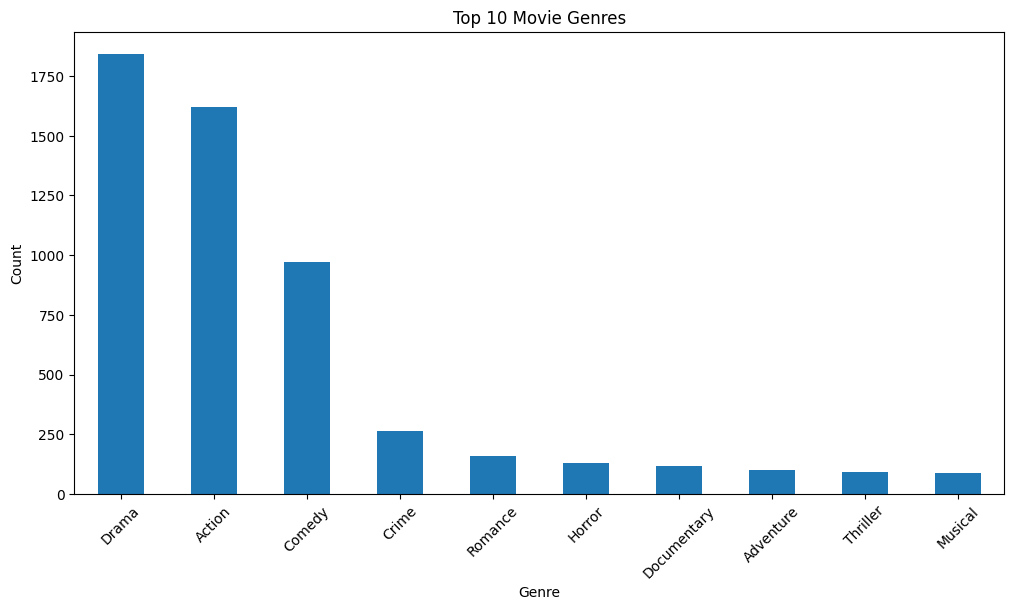

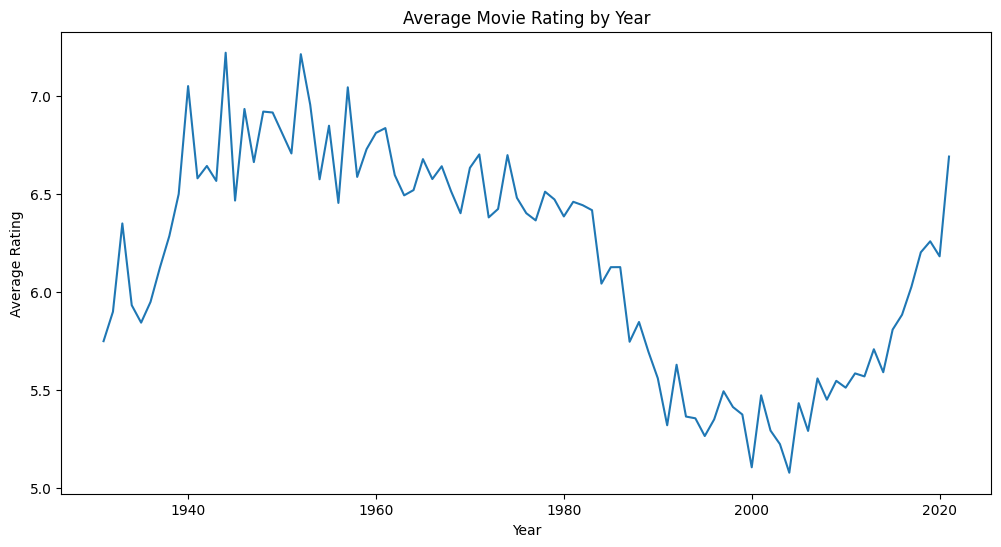

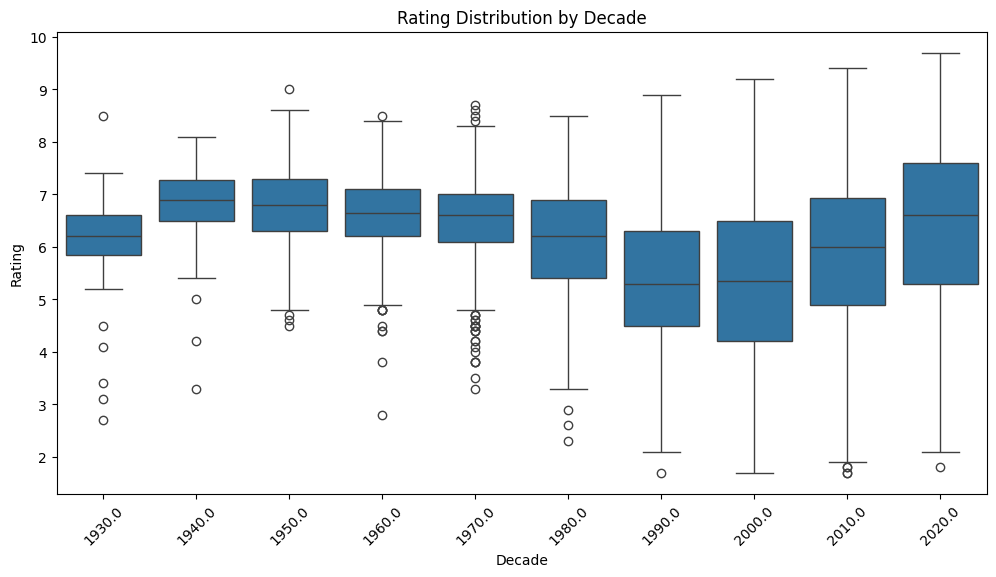

In [26]:
def create_advanced_visualizations(df):
    # Genre Distribution
    plt.figure(figsize=(12, 6))
    try:
        genre_split = df['Genre'].str.split(',', expand=True).stack()
        genre_split = genre_split[genre_split != ''].dropna()
        genre_split.value_counts().head(10).plot(kind='bar')
    except Exception as e:
        print(f"Error processing genres: {e}")
    plt.title('Top 10 Movie Genres')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    # Rating Trends Over Time
    plt.figure(figsize=(12, 6))
    yearly_ratings = df.groupby('Year')['Rating'].mean()
    yearly_ratings.plot(kind='line')
    plt.title('Average Movie Rating by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.show()

    # Box Plot of Ratings by Decade
    df['Decade'] = (df['Year'] // 10) * 10  # Create Decade column
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Decade', y='Rating')
    plt.title('Rating Distribution by Decade')
    plt.xticks(rotation=45)
    plt.show()

# Create advanced visualizations
create_advanced_visualizations(df_clean)


Number of Popular Movies Released Each Year:
Year
1931.0      2
1932.0      2
1933.0      2
1934.0      3
1935.0      9
         ... 
2017.0    217
2018.0    203
2019.0    229
2020.0    136
2021.0     65
Name: Name, Length: 91, dtype: int64

Yearly Votes and Rating Performance:
           Votes    Rating
Year                      
1931.0     118.0  5.750000
1932.0      25.0  5.900000
1933.0      22.0  6.350000
1934.0      22.0  5.933333
1935.0     119.0  5.844444
...          ...       ...
2017.0  478185.0  6.027189
2018.0  611044.0  6.202956
2019.0  569918.0  6.258952
2020.0  441074.0  6.182353
2021.0   95757.0  6.690769

[91 rows x 2 columns]

Overall Votes and Rating Performance:
Votes     8.964898e+06
Rating    5.909584e+00
dtype: float64

Most Prolific Director: David Dhawan

Most Frequent Actor: Mithun Chakraborty


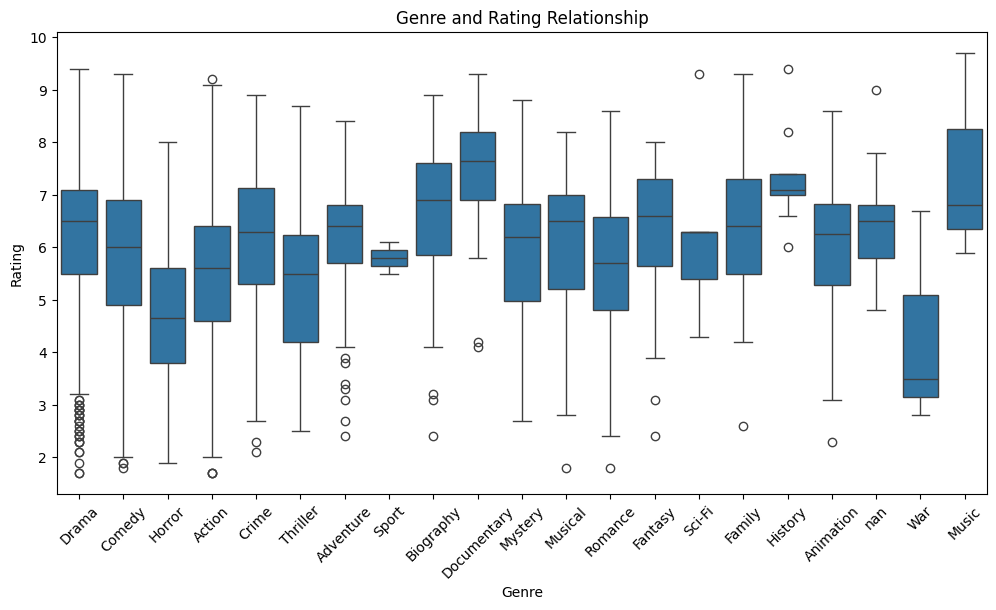

In [27]:
def extended_analysis(df):
    # 1. Number of Popular Movies Released Each Year
    popular_movies_per_year = df.groupby('Year')['Name'].count()
    print("\nNumber of Popular Movies Released Each Year:")
    print(popular_movies_per_year)

    # 2. Number of Votes and Rating Performance
    # a. Per Year
    yearly_votes_rating = df.groupby('Year').agg({'Votes': 'sum', 'Rating': 'mean'})
    print("\nYearly Votes and Rating Performance:")
    print(yearly_votes_rating)

    # b. Overall
    overall_votes_rating = df.agg({'Votes': 'sum', 'Rating': 'mean'})
    print("\nOverall Votes and Rating Performance:")
    print(overall_votes_rating)

    # 3. Most Prolific Director
    most_prolific_director = df['Director'].value_counts().idxmax()
    print("\nMost Prolific Director:", most_prolific_director)

    # 4. Most Frequent Actor
    all_actors = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']]).dropna()
    most_frequent_actor = all_actors.value_counts().idxmax()
    print("\nMost Frequent Actor:", most_frequent_actor)

    # 5. Other Trends and Future Predictions
    # - You can analyze the relationship between genre and rating using box plots or violin plots.
    # - Explore correlations between different numerical features (e.g., duration, votes, rating).
    # - Investigate trends in specific genres or directors over time.
    # - Use time series analysis or forecasting techniques to predict future trends in movie ratings or popularity.

    # Example: Genre and Rating Relationship
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Genre', y='Rating')
    plt.title('Genre and Rating Relationship')
    plt.xticks(rotation=45)
    plt.show()

# Call the extended analysis function
extended_analysis(df_clean)

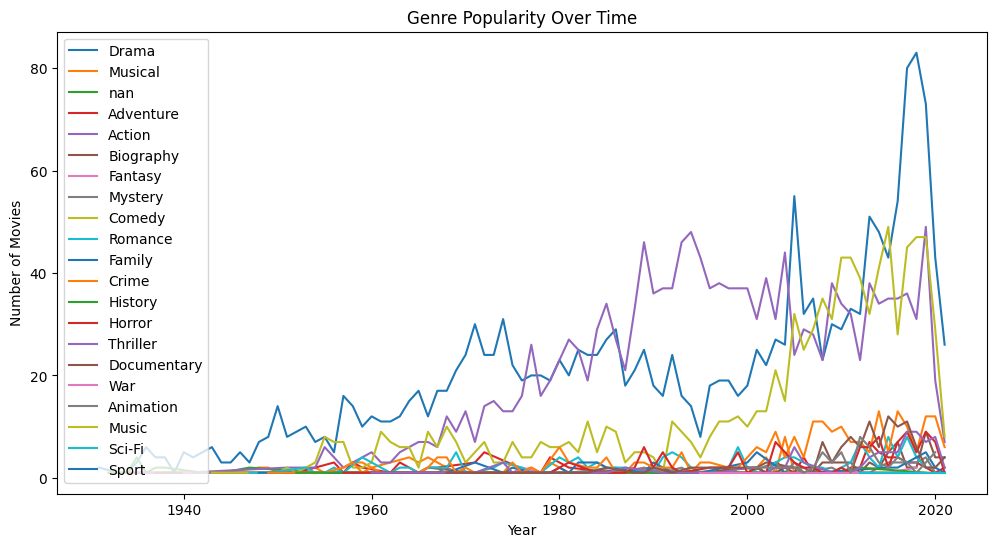

In [28]:
def advanced_analysis(df):
    # 1. Genre Popularity Over Time:
    genre_popularity_over_time = df.groupby(['Year', 'Genre'])['Name'].count().reset_index()
    # You can further visualize this using a line plot or heatmap to see genre trends.

    # 2. Actor/Director Collaboration Networks:
    import networkx as nx
    # Create a graph where nodes are actors/directors and edges represent collaborations.
    # Analyze network properties like centrality to identify key figures in the industry.

    # 3. Sentiment Analysis of Movie Titles/Descriptions:
    # Using libraries like NLTK or TextBlob, analyze the sentiment expressed in movie titles or descriptions.
    # Explore if sentiment correlates with movie ratings or popularity.

    # 4. Clustering Movies Based on Features:
    # Use clustering algorithms (e.g., K-Means) to group movies based on features like genre, rating, votes, etc.
    # Analyze the characteristics of each cluster to understand different types of movies.

    # 5. Predictive Modeling:
    # Build models to predict movie ratings or success based on features like genre, director, actors, etc.
    # Use techniques like linear regression, decision trees, or random forests.

    # Example: Genre Popularity Over Time (Line Plot)
    plt.figure(figsize=(12, 6))
    for genre in genre_popularity_over_time['Genre'].unique():
        genre_data = genre_popularity_over_time[genre_popularity_over_time['Genre'] == genre]
        plt.plot(genre_data['Year'], genre_data['Name'], label=genre)
    plt.title('Genre Popularity Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.legend(loc='upper left')
    plt.show()

# Call the advanced analysis function
advanced_analysis(df_clean)

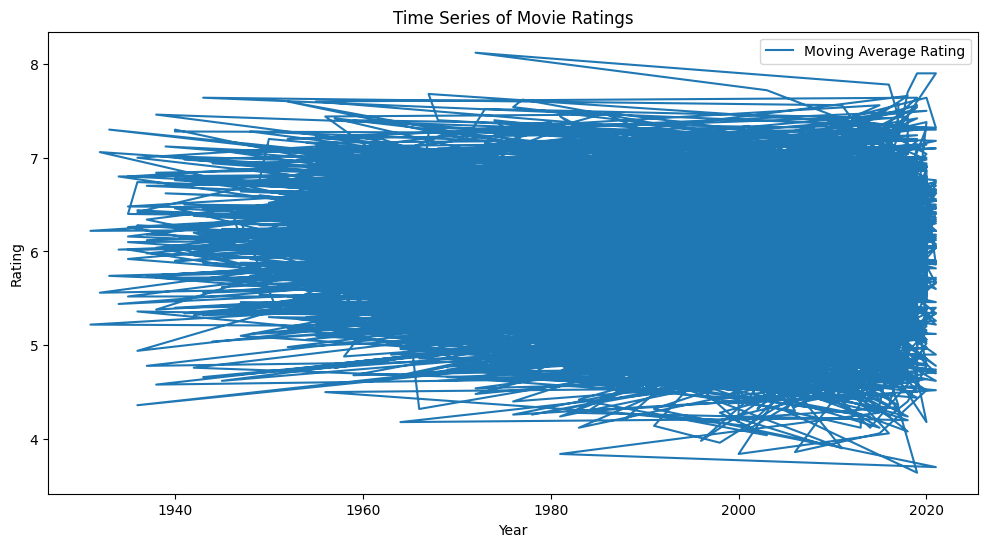

In [29]:
def further_advanced_analysis(df):
    # 1. Time Series Analysis of Movie Ratings:
    # Use techniques like moving averages or ARIMA models to analyze trends and seasonality in movie ratings over time.
    # This can help identify periods of high or low ratings and predict future rating patterns.

    # 2. Topic Modeling of Movie Descriptions:
    # Apply topic modeling algorithms (e.g., Latent Dirichlet Allocation - LDA) to extract hidden topics from movie descriptions.
    # Analyze the topics to understand common themes and categorize movies based on their content.

    # 3. Recommender Systems:
    # Build collaborative filtering or content-based recommender systems to suggest movies to users based on their preferences or similar movie characteristics.
    # This can enhance user experience and engagement.

    # 4. Social Network Analysis of Actors/Directors:
    # Extend the collaboration network analysis by incorporating social media data or other sources to analyze the influence and connections of actors and directors within the industry.
    # Identify key influencers and their impact on movie trends.

    # 5. Geospatial Analysis of Movie Locations:
    # If you have data on movie filming locations, use geospatial analysis techniques to visualize and analyze the spatial distribution of movies.
    # Explore regional trends in movie production or identify popular filming locations.

    # Example: Time Series Analysis of Movie Ratings (Moving Average)
    df['Rating_MA'] = df['Rating'].rolling(window=5, center=True).mean() # 5-year moving average
    plt.figure(figsize=(12, 6))
    plt.plot(df['Year'], df['Rating_MA'], label='Moving Average Rating')
    plt.title('Time Series of Movie Ratings')
    plt.xlabel('Year')
    plt.ylabel('Rating')
    plt.legend()
    plt.show()

# Call the further advanced analysis function
further_advanced_analysis(df_clean)